<a href="https://colab.research.google.com/github/DDGanji/GanjiPythonClass/blob/main/pde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 pip install gekko

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.1 MB 15.3 MB/s 


apm 34.90.136.189_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          101
   Intermediates:            0
   Connections  :            0
   Equations    :          100
   Residuals    :          100
 
 Number of state variables:          20000
 Number of total equations: -        20000
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains I

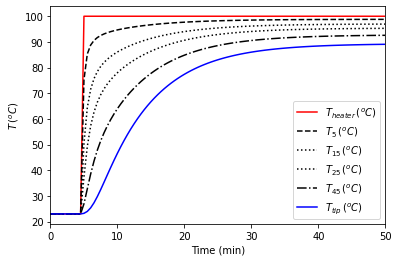

In [4]:
# The parabolic PDE equation describes the evolution of temperature
#  for the interior region of the rod. This model is modified to make
#  one end of the rod fixed and the other temperature at the end of the
#  rod calculated.
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

# Steel rod temperature profile
# Diameter = 3 cm
# Length = 10 cm
seg      = 100              # number of segments
T_melt   = 1426             # melting temperature of H13 steel
pi       = 3.14159          # pi
d        = 3 / 100          # rod diameter (m)
L        = 10 / 100         # rod length (m)
L_seg    = L / seg          # length of a segment (m)
A        = pi * d**2 / 4    # rod cross-sectional area (m)
As       = pi * d * L_seg   # surface heat transfer area (m^2)
heff     = 5.8              # heat transfer coeff (W/(m^2*K))
keff     = 28.6             # thermal conductivity in H13 steel (W/m-K)
rho      = 7760             # density of H13 rod steel (kg/m^3)
cp       = 460              # heat capacity of H13 steel (J/kg-K)
Ts       = 23               # temperature of the surroundings (°C)
c2k      = 273.15           # Celcius to Kelvin

m = GEKKO()  # create GEKKO model

tf = 3000
nt = int(tf/30) + 1
m.time = np.linspace(0,tf,nt)
Th = m.MV(ub=T_melt)        # heater temperature (°C)    
Th.value = np.ones(nt) * 23 # start at room temperature
Th.value[10:] = 100         # step at 300 sec

T = [m.Var(23) for i in range(seg)] # temperature of the segments (°C)

# Energy balance for the rod (segments)
# accumulation =
#    (heat gained from upper segment)
#  - (heat lost to lower segment)
#  - (heat lost to surroundings)
# Units check
# kg/m^3 * m^2 * m * J/kg-K * K/sec =
#     W/m-K   * m^2 *  K / m
#  -  W/m-K   * m^2 *  K / m
#  -  W/m^2-K * m^2 *  K

# first segment
m.Equation(rho*A*L_seg*cp*T[0].dt() == \
               keff*A*(Th-T[0])/L_seg \
             - keff*A*(T[0]-T[1])/L_seg \
             - heff*As*(T[0]-Ts))
# middle segments
m.Equations([rho*A*L_seg*cp*T[i].dt() == \
               keff*A*(T[i-1]-T[i])/L_seg \
             - keff*A*(T[i]-T[i+1])/L_seg \
             - heff*As*(T[i]-Ts) for i in range(1,seg-1)])
# last segment
m.Equation(rho*A*L_seg*cp*T[seg-1].dt() == \
             keff*A*(T[seg-2]-T[seg-1])/L_seg \
           - heff*(As+A)*(T[seg-1]-Ts))

# simulation
m.options.IMODE = 4
m.solve()

# plot results
plt.figure()
tm = m.time / 60.0
plt.plot(tm,Th.value,'r-',label=r'$T_{heater}\,(^oC)$')
plt.plot(tm,T[5].value,'k--',label=r'$T_5\,(^oC)$')
plt.plot(tm,T[15].value,'k:',label=r'$T_{15}\,(^oC)$')
plt.plot(tm,T[25].value,'k:',label=r'$T_{25}\,(^oC)$')
plt.plot(tm,T[45].value,'k-.',label=r'$T_{45}\,(^oC)$')
plt.plot(tm,T[-1].value,'b-',label=r'$T_{tip}\,(^oC)$')
plt.ylabel(r'$T\,(^oC$)')
plt.xlabel('Time (min)')
plt.xlim([0,50])
plt.legend(loc=4)
plt.show()